In [1]:
from LensCalcPy.survey import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson

%load_ext autoreload
%autoreload 2

In [2]:
# HSC Params
# l = 121.2
# b = -21.6
# ds = 770
# obsTime = 7
# survey_area = 0
# n_sources = 8.7e7
# efficiency = 0.5
from LensCalcPy.parameters import *

In [3]:
s = Survey(l, b, ds, obsTime, survey_area=survey_area, n_sources=n_sources)
s

Survey(l=121.2, b=-21.6, source_dist=770, obs_time=7, survey_area=0)

In [4]:
t_es = np.logspace(-2, 3, 20) #hours

In [5]:
m = 1e-10
alpha = 2
# s.add_pbh(m)
s.add_ffp(mlow=m, alpha=alpha)
diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=False)

In [6]:
diff_rates_finite = s.get_crossing_times_rates_ffp(t_es, finite=True)

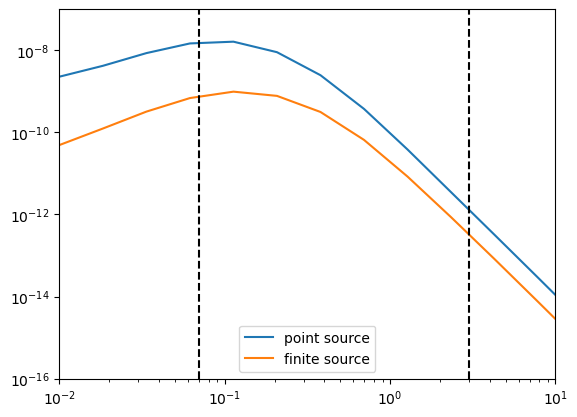

In [7]:
plt.loglog(t_es, diff_rates, label='point source')
plt.loglog(t_es, diff_rates_finite, label='finite source')

# Add lines for HSC sensitivity window
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')
plt.xlim(1e-2, 1e1)
plt.ylim(1e-16,1e-7)
plt.legend()
plt.show()

In [8]:
diff_rate_interp = interp1d(t_es, diff_rates)

In [9]:
ti = 0.07
tf = 3
dnds = quad(diff_rate_interp, ti, tf)[0]

In [10]:
s.n_sources*efficiency*dnds

0.17739882109356536

In [11]:
def get_n_events(m, alpha=2, finite=False):
    s.add_ffp(m, alpha=alpha)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime

def get_n_events_parallel(mass_arr, alpha=2, finite=False):
    with Pool() as p:
        f = functools.partial(get_n_events, alpha=alpha, finite=finite)
        results = list(tqdm(p.imap(f, mass_arr), total=len(mass_arr)))
    return results

def get_constraint_fdm(m, finite=False):
    n_events = get_n_events(m, finite=finite)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1

In [12]:
mlow_ffps = np.logspace(-15, -5, 10)
n_events_arr = get_n_events_parallel(mlow_ffps, alpha=alpha, finite=False)

100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


In [13]:
n_events_arr_finite = get_n_events_parallel(mlow_ffps, alpha=alpha, finite=True)

100%|██████████| 10/10 [00:40<00:00,  4.06s/it]


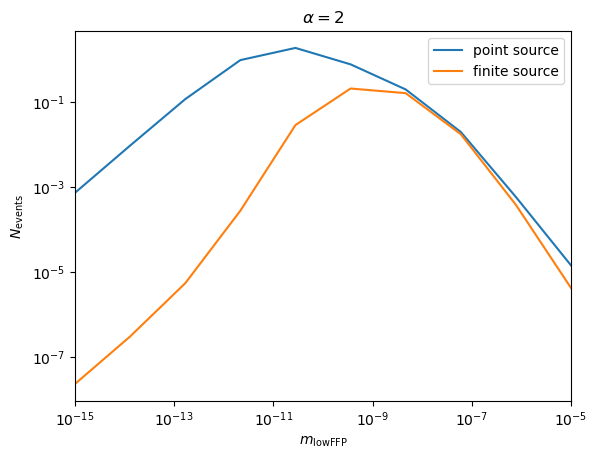

In [14]:
plt.loglog(mlow_ffps, n_events_arr, label='point source')
plt.loglog(mlow_ffps, n_events_arr_finite, label='finite source')
plt.xlabel(r'$m_{\rm low FFP}$')
plt.ylabel(r'$N_{\rm events}$')
plt.title(r'$\alpha = {}$'.format(alpha))
plt.xlim(1e-15, 1e-5)
# plt.ylim(1e-6, 1e-3)
plt.legend()
plt.show()

## 2D exclusion plots

In [28]:
def get_n_events(A, alpha=2, finite=False):
    #We know the survey isn't sensitive to masses below about 1e-12
    m_low = 1e-12
    s.add_ffp(m_low, alpha=alpha)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime*A

def get_n_events_parallel(As, alpha=2, finite=False):
    with Pool() as p:
        f = functools.partial(get_n_events, alpha=alpha, finite=finite)
        results = list(p.imap(f, As))
    return results

In [174]:
A_min = 1
A_max = 1e8
alpha_min = 1.1
alpha_max = 2.5
num_points = 20
A_values = np.logspace(np.log10(A_min), np.log10(A_max), num_points)
alpha_values = np.linspace(alpha_min, alpha_max, num_points) 
A_grid, alpha_grid = np.meshgrid(A_values, alpha_values)

get_n_events_values = np.empty_like(A_grid)

for i in tqdm(range(len(alpha_values))):
    get_n_events_values[i] = get_n_events_parallel(A_values, alpha=alpha_values[i], finite=False)
    

100%|██████████| 20/20 [15:36<00:00, 46.81s/it]


In [178]:
n_events_interp = interp2d(A_values, alpha_values, get_n_events_values, kind='cubic')

In [179]:
A_values_dense = np.logspace(np.log10(A_min), np.log10(A_max), num_points*10)
alpha_values_dense = np.linspace(alpha_min, alpha_max, num_points*10) 
n_events_interp_dense = n_events_interp(A_values_dense, alpha_values_dense)

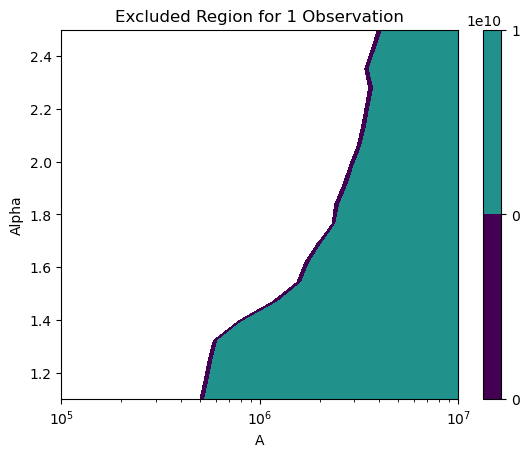

In [185]:
plt.figure()
contour = plt.contourf(A_grid, alpha_grid, get_n_events_values, levels=[4.49, 4.74, 1e10])
# contour = plt.contourf(A_values_dense, alpha_values_dense, n_events_interp_dense, levels=[4.49, 4.74, 1e10])
plt.colorbar(contour)
plt.xscale('log')
plt.title('Excluded Region for 1 Observation')
plt.xlabel('A')
plt.ylabel('Alpha')
plt.xlim(1e5,1e7)
plt.ylim(1.1,2.5)
plt.show()

In [195]:
def max_objects_above_threshold(m_threshold, A, alpha):
    # Calculate the total number of objects using get_n_events
    total_objects = get_n_events(A, alpha)

    # Calculate the proportion of objects with masses greater than m_threshold
    proportion_above_threshold = (1e-12 / m_threshold) ** alpha

    # Calculate the expected number of ISOs with masses greater than m_threshold
    objects_above_threshold = total_objects * proportion_above_threshold 

    return objects_above_threshold

In [196]:
max_objects_above_threshold(1e-9,1e6,1.2)

0.0021117821181996944

In [161]:
confidence_level_threshold = 0.05

Nexp = 1

# Calculate the cumulative probability until it exceeds the threshold
while True:
    # cumulative_prob = poisson.pmf(0, Nexp) + poisson.pmf(1, Nexp) 
    cumulative_prob = poisson.pmf(1, Nexp) 
    if cumulative_prob <= confidence_level_threshold:
        break
    Nexp += 0.01 

print(f"The 95% C.L. is reached when Nexp <= {Nexp}")

The 95% C.L. is reached when Nexp <= 4.499999999999948
